# HW 1. Логистическая регрессия

In [35]:
#from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Загрузка данных

Для того чтобы загрузить данные в нейросеть или более простые алгоритмы ML, их необходимо должным образом открыть и преобразовать в вектор с числами. Для этого воспользуемся функцией ```read_files()```.

Этот парсер делает следующие вещи:
 - открывает файл картинки с диска (с помощью библиотеки opencv),
 - проверяет, что картинка действительно открылась и сейчас является матрицей (```np.array```),
 - преобразует матрицу в вектор (путем записи всех столбцов друг под другом),
 - возвращает массив из векторов, в которых хранятся картинки, и лейбл, соответствующий каждой картинке.

In [36]:
def read_files(path: str, ans: int, target_dim: tuple = (256, 256)):
    files = os.listdir(path)
    X = None
    for i, name in enumerate(files):
        img = cv2.imread(path + '/' + name, 0) # 0 means black-white picture
        if img.shape != 0:
            img = cv2.resize(img, (256, 256))
            vect = img.reshape(1, 256 ** 2) / 255.

            X = vect if (X is None) else np.vstack((X, vect))
    y = np.ones((len(X),1)) * ans
    return X, y

Логика программы следующая:
 - есть класс ```LogisticRegression```. Он содержит веса модели и нужен для того, чтобы генерировать предсказания. Также, этот класс снабжен методом backward() для возможности дифференцирования функции потерь по весам этого класса.
 - есть класс ```Loss```. Он определяет функцию потерь, которую мы хотим использовать. Также, этот класс осуществляет подсчет градиентов функции потерь по всем весам модели.
 - есть класс ```Optimizer```. Он отвечает за то, как будут обновляться веса после подсчета градиентов (после работы класса ```Loss```). Сегодня мы рассматриваем простой градиентный спуск, но более сложные модели используют более усовершенствованные алгоритмы оптимизации.

То есть:
 1. Вызывается метод ```forward()``` нашей модели (логистической регрессии). После этого у нас выводятся текущие предсказания модели.
 2. Вызывается метод ```loss()```, который сравнивает предсказания модели с истинными ответами. После этого подсчитываются градиенты функции потерь по всем весам модели.
 3. Подсчитанные градиенты вычитаются из весов (происходит шаг градиентного спуска) путем вызова ```optimizer.step()```

In [37]:
class LogisticRegression:
    def __init__(self, n_features):
        pass


    def predict(self, X: np.array):
        pass


# Задание

1. Загрузить датасет, разбить его на два датасета: первый для обучения, второй - для проверки качества (см. функцию [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))
2. Посчитать производные функции потерь по w и по b
3. Реализовать цикл обучения, обновляя параметры логистической регрессии:
$$w = w - \alpha \cdot \frac{\partial L}{\partial w}$$

$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$

Обратите внимание на величину $\alpha$. Ее надо подобрать, иначе алгоритм не будет обучаться.
4. Посчитать финальное качество модели по метрике [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)



### Загрузка dataset.

In [38]:
x_with_box, y_with_box = read_files('lesson1_dataset/box', ans = 1)
x_without_box, y_without_box = read_files('lesson1_dataset/no_box', ans = 0)

In [39]:
#2/3 dataset for training, 1/3 for testing.
x_with_box_train, x_with_box_test, y_with_box_train, y_with_box_test = train_test_split(x_with_box, y_with_box, test_size=0.33, random_state = 42)
x_without_box_train, x_without_box_test, y_without_box_train, y_without_box_test = train_test_split(x_without_box, y_without_box, test_size=0.33, random_state = 42)

In [40]:
x_train = np.vstack([x_with_box_train, x_without_box_train])
y_train = np.vstack([y_with_box_train, y_without_box_train])
x_test = np.vstack([x_with_box_test, x_without_box_test])
y_test = np.vstack([y_with_box_test, y_without_box_test])

### Писать класс ```LogisticRegression```.
Вероятность на выходе модели вычисляется по формуле:
$$ z = \sum_{i=0}^{N-1} w_i x_i  + b $$
$$ \hat{y} = sigmoid(z) $$

In [41]:
class LogisticRegression:
    def __init__(self, n_features: int):
        self.w = np.zeros(n_features)
        self.b = 0
    def predict(self, X: np.ndarray) -> np.ndarray:
        # X have shape (batch_size, n_features)
        logit = np.dot(X, self.w) + self.b
        prob = 1/(1+np.exp(-logit))
        # X have shape (batch_size, 1)
        return prob[:, np.newaxis]

### Писать класс ```Loss```.
У класса есть три метода:
* метод ```compute_loss()``` вычисляет значение функции  $ L(y, \hat{y}(x, w, b)) $.
$$ L = -\sum_{k=0}^{S-1} y_k\ln{\hat{y}_k} - (1-y_k)\ln{(1-\hat{y}_k)} $$
* метод ```devivative_w()``` вычисляет производные $ (\frac{\partial L}{\partial w_0}, ... , \frac{\partial L}{\partial w_{N-1}})^T $.
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} \frac{\partial}{\partial \hat{y}_k} \left( y_k\ln{\hat{y}_k} - (1-y_k)\ln{(1-\hat{y}_k)} \right) \frac{\partial \hat{y}_k}{\partial w_i} $$
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} \left(-\frac{y_k}{\hat{y}_k} + \frac{1 - y_k}{1-\hat{y}_k}\right) \frac{\partial \hat{y}_k}{\partial w_i}$$
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} \frac{\hat{y}_k - y_k \hat{y}_k - y_k + y_k \hat{y}_k}{\hat{y}_k(1 - \hat{y}_k)} \frac{\partial \hat{y}_k}{\partial z_k} \frac{\partial z_k}{\partial w_i} $$
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} \frac{\hat{y}_k - y_k}{\hat{y}_k(1 - \hat{y}_k)} \hat{y}_k(1-\hat{y}_k) x_{ki} $$
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} (\hat{y}_k - y_k) x_{ki} $$
Производная ```sigmoid``` функции: $ \frac{\partial \hat{y}}{\partial z} = \hat{y} (1-\hat{y}) $.

* метод ```derivative_b()``` вычисляет производную $ \frac{\partial L}{\partial b} $.
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} (\hat{y}_k - y_k)  \frac{\partial z_k}{\partial b} $$
$$ \frac{\partial L}{\partial w_i} = \sum_{k=0}^{S-1} (\hat{y}_k - y_k) $$

N - number of fearures.

S - dataset size.



In [42]:
class Loss:
    def compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return - np.sum(y_true*np.log(y_pred)) - np.sum((1-y_true)*np.log(1 - y_pred))

    def derivative_w(self, y_true: np.ndarray, y_pred: np.ndarray, x:np.ndarray) -> np.ndarray:
        return np.sum(x*(y_pred - y_true), axis = 0)
    
    def derivative_b(self, y_true: np.ndarray, y_pred: np.ndarray, x:np.ndarray) -> np.ndarray:
        return np.sum(y_pred - y_true, axis = 0)

### Реазизовать цикл обучения.

In [43]:
def train(x_train: np.ndarray, y_train: np.ndarray, x_test:np.ndarray, y_test: np.ndarray, model: LogisticRegression, loss: Loss, learning_rate: float, 
          epoch: int) -> tuple[list[np.ndarray], list[np.ndarray]]:
    losses_on_train_data = []
    losses_on_test_data = []
    losses_on_train_data.append(loss.compute_loss(y_train, model.predict(x_train)))
    losses_on_test_data.append(loss.compute_loss(y_test, model.predict(x_test)))
    for i in range(epoch):
        model.w -= learning_rate*loss.derivative_w(y_train, model.predict(x_train), x_train)
        model.b -= learning_rate*loss.derivative_b(y_train, model.predict(x_train), x_train)

        losses_on_train_data.append(loss.compute_loss(y_train, model.predict(x_train)))
        losses_on_test_data.append(loss.compute_loss(y_test, model.predict(x_test)))
    return losses_on_train_data, losses_on_test_data

### Обучить модель.

In [44]:
model = LogisticRegression(256**2)
loss = Loss()
losses_on_train_data, losses_on_test_data = train(x_train, y_train, x_test, y_test, model, loss, learning_rate=0.001, epoch=1200)

/tmp/ipykernel_40831/3996553000.py:3: RuntimeWarning: divide by zero encountered in log
  return - np.sum(y_true*np.log(y_pred)) - np.sum((1-y_true)*np.log(1 - y_pred))
/tmp/ipykernel_40831/3996553000.py:3: RuntimeWarning: invalid value encountered in multiply
  return - np.sum(y_true*np.log(y_pred)) - np.sum((1-y_true)*np.log(1 - y_pred))


### Зависимости значения этой функции от итерации оптимизации на трейне и на тесте.

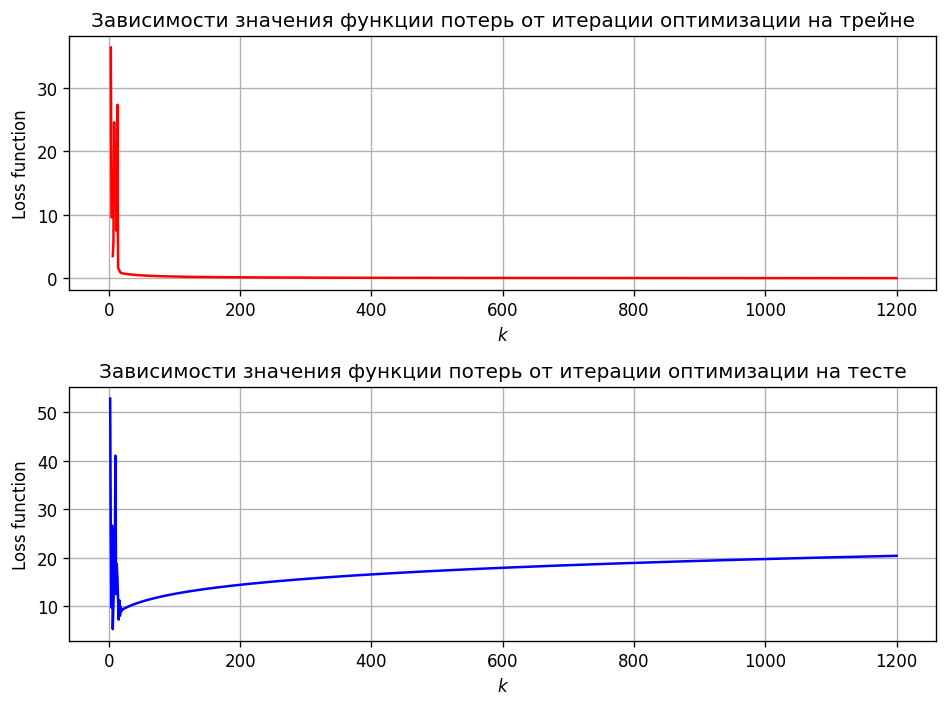

In [45]:
k = np.arange(len(losses_on_train_data))
fig, axs = plt.subplots(2, 1, figsize=[8, 6], dpi = 120)

axs[0].plot(k, losses_on_train_data, color='red')
axs[0].set_xlabel("$k$")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Зависимости значения функции потерь от итерации оптимизации на трейне")
axs[0].grid()

axs[1].plot(k, losses_on_test_data, color='blue')
axs[1].set_xlabel("$k$")
axs[1].set_ylabel("Loss function")
axs[1].set_title("Зависимости значения функции потерь от итерации оптимизации на тесте")
axs[1].grid()

fig.tight_layout()
plt.show()

### Посчитать финальное качество модели по метрике [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [46]:
ans_for_test_set = [1 if i>0.5 else 0 for i in np.squeeze(model.predict(x_test), axis=-1)]
ans_for_train_set = [1 if i>0.5 else 0 for i in np.squeeze(model.predict(x_train), axis=-1)]
print('Accuracy score for train dataset: ', accuracy_score(ans_for_train_set, np.squeeze(y_train, axis=-1)))
print('Accuaracy score for test dataset: ', accuracy_score(ans_for_test_set, np.squeeze(y_test, axis=-1)))

Accuracy score for train dataset:  1.0
Accuaracy score for test dataset:  0.8666666666666667
